In [1]:
from extra import *
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras import regularizers
from keras.layers import Dense, Dropout, Conv2D,  Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Add, Concatenate, BatchNormalization
import keras.backend as K
from keras.optimizers import Adam

import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

batch_size = 128
num_classes = 10

# input image dimensions
HEIGHT, WIDTH = 28, 28
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [4]:
print('pixel range',x_train.min(), x_train.max())

pixel range 0 255


images are as pixel values, ranging from 0-255

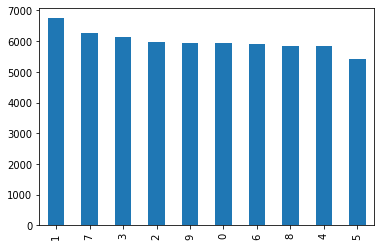

In [5]:
pd.DataFrame(y_train)[0].value_counts().plot(kind='bar')

In [6]:
## changes pixel range to 0 to 1
def normalize(images):
    images /= 255. 
    return images

In [7]:
x_train = normalize(x_train.astype(np.float32))
x_test = normalize(x_test.astype(np.float32))
x_train = x_train.reshape(x_train.shape[0], 1, WIDTH, HEIGHT)
x_test = x_test.reshape(x_test.shape[0], 1, WIDTH, HEIGHT)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

now we have images that are normalized, and labels are one hot encoded

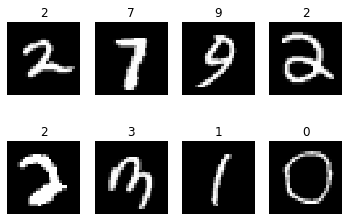

In [8]:
def show_images(rows, columns):
    fig, axes = plt.subplots(rows,columns)
    for rows in axes:
        for ax in rows:
            idx = np.random.randint(0, len(y_train))
            ax.title.set_text(np.argmax(y_train[idx]))
            ax.imshow(x_train[idx][0], cmap='gray')
            ax.axis('off')
    plt.show()
    
show_images(2,4)

In [9]:
def build_model():
    inp = Input((1, HEIGHT, WIDTH))
    
    x = Conv2D(16, kernel_size=(7,7), strides=(2,2), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(inp)
    x = BatchNormalization()(x)
    
    y = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
    y = BatchNormalization()(y)
    y = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(y)
    y = BatchNormalization()(y)
    x = Add()([x,y])
    x = Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
    x = BatchNormalization()(x)
    
    
    y = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
    y = BatchNormalization()(y)
    y = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(y)
    y = BatchNormalization()(y)
    x = Add()([x,y])
    x = Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
    x = BatchNormalization()(x)
    
    x = Concatenate()([GlobalMaxPooling2D(data_format='channels_first')(x) , GlobalAveragePooling2D(data_format='channels_first')(x)])
    x = Dropout(0.3)(x)
    
    out = Dense(10, activation='softmax')(x)
    
    return Model(inputs=inp, outputs=out)
    

In [10]:
model = build_model()

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 14, 14)   800         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 14, 14)   56          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 14, 14)   2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [12]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [13]:
K.get_value(model.optimizer.lr), K.get_value(model.optimizer.beta_1)

(0.001, 0.9)

Epoch 1/10
20192/60000 [=========>....................] - ETA: 12s - loss: 3.8787 - acc: 0.5828stopping


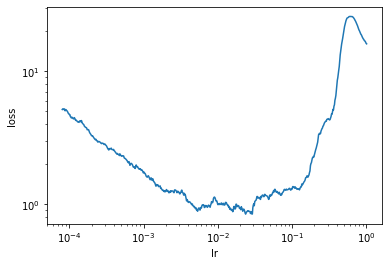

In [14]:
lr_find(model, (x_train, y_train)) ## use generator if using generator insted of data, i.e, (x_train, y_train) and pass parameter, generator=True

selecting lr as 2e-3

In [15]:
recorder = RecorderCallback()
clr = CyclicLRCallback(max_lr=0.1, cycles=16, decay=0.7, DEBUG_MODE=True, patience=1, auto_decay=True) #high lr for demonstration, from above graph 0.001 0r 0.002 seems nice

In [16]:
K.get_value(model.optimizer.lr), K.get_value(model.optimizer.beta_1)

(0.001, 0.9)

In [17]:
model.fit(x_train, y_train, batch_size=128, epochs=32, callbacks=[recorder, clr], validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
epochs: 32 , steps per cycle: 938.0 , total steps: 15008.0 , cycles: 16 , max_lr: 0.10000010000000001
Epoch 1/32

cycle no.:  1

cycle 1 end status: 0.10000010000000001 0.0 0.95
60000/60000 [==============================] - 5s 81us/step - loss: 0.9101 - acc: 0.8484 - val_loss: 4.9706 - val_acc: 0.1135

at epoch 1 end, batch num:  469
check at epoch end, epoch  1 curr_cycle:  1 best:  inf
Epoch 2/32
60000/60000 [==============================] - 5s 78us/step - loss: 0.3916 - acc: 0.9550 - val_loss: 0.4315 - val_acc: 0.9084

at epoch 2 end, batch num:  938
check at epoch end, epoch  2 curr_cycle:  1 best:  inf
Epoch 3/32

cycle no.:  2

cycle 2 end status: 0.10000010000000001 0.0 0.95
60000/60000 [==============================] - 5s 83us/step - loss: 0.5339 - acc: 0.9411 - val_loss: 1.1165 - val_acc: 0.8101

at epoch 3 end, batch num:  1407
check at epoch end, epoch  3 curr_cycle:  2 best:  0.4315095308303833
Epoch 4/32
60000/60000 [===

In [18]:
K.get_value(model.optimizer.lr), K.get_value(model.optimizer.beta_1)

(0.001, 0.9)

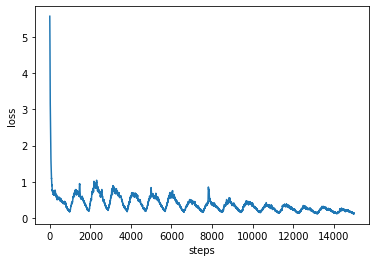

In [19]:
recorder.plot_losses()

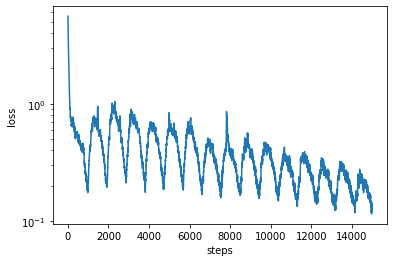

In [20]:
recorder.plot_losses(log=True) #take log scale for loss

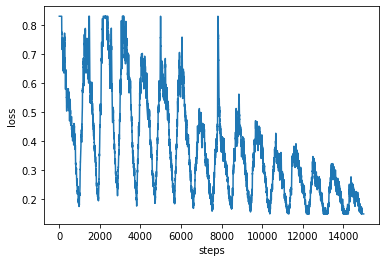

In [21]:
recorder.plot_losses(clip_losses=True) #clips loss between 2.5 and 97.5 precentile

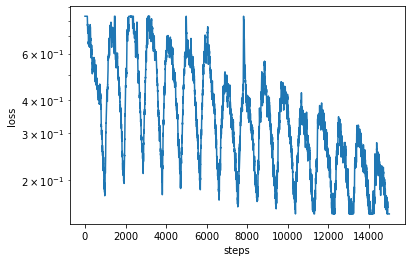

In [22]:
recorder.plot_losses(clip_losses=True, log=True)

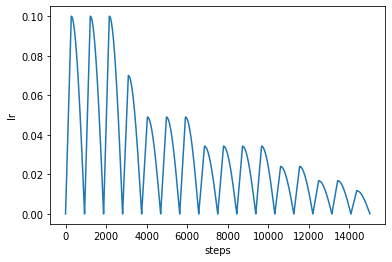

In [23]:
recorder.plot_lr()

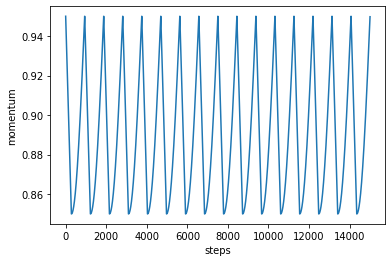

In [24]:
recorder.plot_mom() ##plots momentum, beta_1 in adam family of optimizers

In [25]:
clr.debug_counter

937